# Cardiovascular Data Analysis

Hi, welcome to this workshop on walking through some simple algorithms of machine learning!

Dataset:
1. Sex (M/ F)
2. Age 
3. Duration of Symptoms for CAD
4. Cholesterol Level
5. Significant CAD? (1/0)
6. Three Vessel or Left Main Disease? (1/0)

Today, we're going to review:
1. Linear Regression
2. Logistic Regression
3. Random Forest


## Import Libraries to Conduct Analysis

In [76]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import *
from matplotlib import pyplot as plt

from IPython.display import display
import random
random.seed(9001)

# import piping and linear models
import sklearn
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.lda import LDA

# import ensemble techniques
from sklearn.ensemble import RandomForestClassifier

# import feature selection
from sklearn.feature_selection import SelectKBest

# import train/test splitting
from sklearn.model_selection import train_test_split

%matplotlib inline

## 0. Import Data And Summarize

It's important to understand the data and some basic characteristics before analyzing it. Here we see that the disease output is either 0, or 1, so we want to do a binary classification. 

Objective: Our objective is to find a boundary between disease, or not diseased based on our features, age, sex, symptom duration, and cholesterol level.

*** No CODEPAGE record, no encoding_override: will use 'ascii'
Age nan's,  0
CAD Symptom Duration nan's,  0
Cholesterol nan's,  1246
Significant CAD nan's,  0
TVDLM nan's,  3


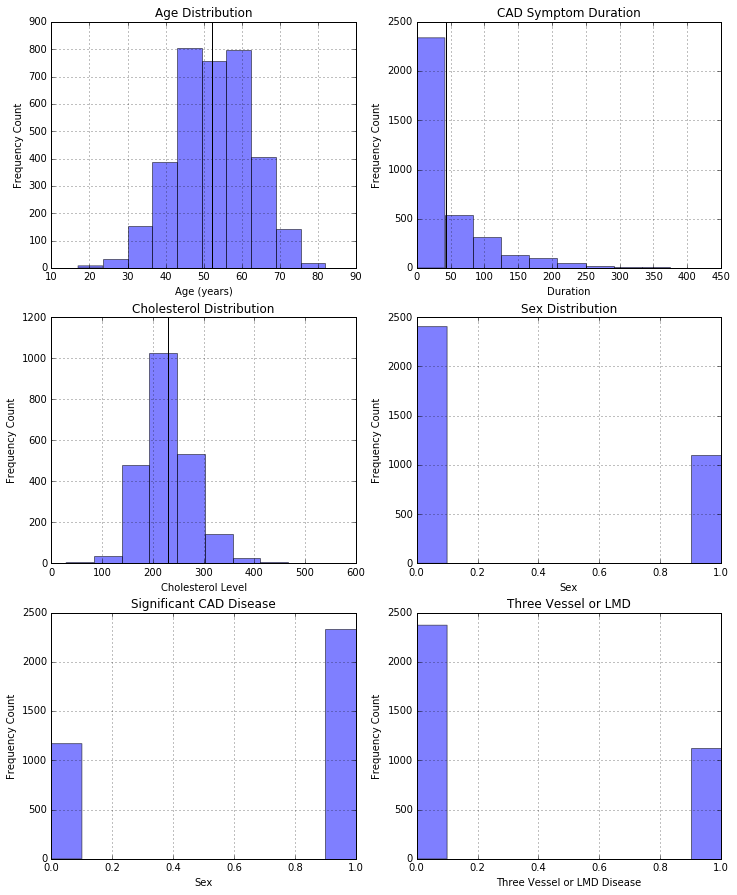

In [3]:
# Use Pandas to read in the excel file
cathdata = pd.read_excel('./acath.xls')

# extract different variables and summarize
sex_list = cathdata['sex']
age_list = cathdata['age']
cadsym_list = cathdata['cad.dur']
chol_list = cathdata['choleste']
sigcad_list = cathdata['sigdz']
tvdlm_list = cathdata['tvdlm']

# Plot summary of each variable
fig = plt.figure(figsize=(12, 15))
plt.subplot(3,2,1)
age_list.hist(alpha=0.5)
plt.axvline(np.mean(age_list), color='black')
plt.title('Age Distribution')
plt.xlabel('Age (years)')
plt.ylabel('Frequency Count')

plt.subplot(3,2,2)
cadsym_list.hist(alpha=0.5)
plt.axvline(np.mean(cadsym_list), color='black')
plt.title('CAD Symptom Duration')
plt.xlabel('Duration')
plt.ylabel('Frequency Count')

plt.subplot(3,2,3)
chol_list.hist(alpha=0.5)
plt.axvline(np.mean(chol_list), color='black')
plt.title('Cholesterol Distribution')
plt.xlabel('Cholesterol Level')
plt.ylabel('Frequency Count')

plt.subplot(3,2,4)
sex_list.hist(alpha=0.5)
plt.title('Sex Distribution')
plt.xlabel('Sex')
plt.ylabel('Frequency Count')

plt.subplot(3,2,5)
sigcad_list.hist(alpha=0.5)
plt.title('Significant CAD Disease')
plt.xlabel('Sex')
plt.ylabel('Frequency Count')

plt.subplot(3,2,6)
tvdlm_list.hist(alpha=0.5)
plt.title('Three Vessel or LMD')
plt.xlabel('Three Vessel or LMD Disease')
plt.ylabel('Frequency Count')

# count number of NaN's
print "Age nan's, ", age_list.isnull().sum()
print "CAD Symptom Duration nan's, ", cadsym_list.isnull().sum()
print "Cholesterol nan's, ", chol_list.isnull().sum()
print "Significant CAD nan's, ", sigcad_list.isnull().sum()
print "TVDLM nan's, ", tvdlm_list.isnull().sum()

## 1. Apply Logistic Regression on Significant CAD

An example of logistic regression
![title](figures/logregression.png)

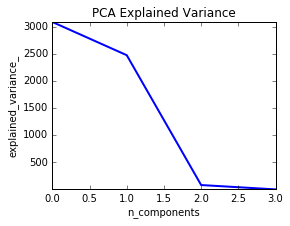

In [15]:
# drop nan entries of data
cleanedcathdata = cathdata.dropna()
features = cleanedcathdata[['sex', 'age', 'cad.dur', 'choleste']]
target_sigdz = cleanedcathdata['sigdz']
target_tvdlm = cleanedcathdata['tvdlm']

# create a cross-validation test/train split
X_train, X_test, y_train, y_test = train_test_split(features, target_sigdz, test_size=0.3, random_state=0)

# initialize the logistic model 
logistic = linear_model.LogisticRegression()

# initialize the prinicple component analysis 
pca = decomposition.PCA()

# apply PCA to the data
pca.fit(features)

plt.figure(1, figsize=(4, 3))
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.title('PCA Explained Variance')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

In [91]:
# parameters for each of the pipeline to test
n_components = [1, 2, 3]
Cs = np.logspace(-4, 4, 5)
penalty = ['l1', 'l2']

# create a pipe of our different operations
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

# create a grid search on different combination of parameters
estimator = GridSearchCV(pipe, dict(
        pca__n_components = n_components,
        logistic__C = Cs,
        logistic__penalty = penalty
    ))

estimator.fit(X_train, y_train)
print estimator.score(X_test, y_test)
print estimator.best_params_

# create a pipe of our different operations
pipe = Pipeline(steps=[('logistic', logistic)])

# create a grid search on different combination of parameters
estimator = GridSearchCV(pipe, dict(
        logistic__C = Cs,
        logistic__penalty = penalty
    ))

estimator.fit(X_train, y_train)
y_predict = estimator.predict(X_test)
report = sklearn.metrics.classification_report(y_test, y_prediction)
print report
print estimator.score(X_test, y_test)
print estimator.best_params_

0.740412979351
{'logistic__C': 1.0, 'pca__n_components': 3, 'logistic__penalty': 'l2'}
             precision    recall  f1-score   support

          0       0.68      0.49      0.57       256
          1       0.73      0.86      0.79       422

avg / total       0.71      0.72      0.71       678

0.738938053097
{'logistic__C': 100.0, 'logistic__penalty': 'l1'}


## 2. Apply Linear Discriminant Analysis

![title](figures/lda.png)

In [42]:
# perform LDA
lda = LDA(n_components=2)

# create a pipe of our different operations
pipe = Pipeline(steps=[('lda', lda), ('logistic', logistic)])

solvers = ['svd', 'lsqr', 'eigen']

# create a grid search on different combination of parameters
estimator = GridSearchCV(pipe, dict(
        lda__solvers = solvers
    ))

# fit lda
lda.fit(X_train, y_train)
Z_labels = lda.predict(X_test)
Z_prob = lda.predict_proba(X_test)

# convert LDA predictions 
predicts = Z_labels
predicts[predicts >= 0.5] = 1
predicts[predicts < 0.5] = 0

print "Accuracy: ", (Z_labels == y_test).sum() / float(len(predicts))

0.741887905605


## 3. Random Forest Predictor

It is difficult to visualize, but essentially it builds a decision tree.

In [51]:
clf = RandomForestClassifier()
select = SelectKBest(k=4)

# create paramters for cross-validation grid search
parameters = dict(feature_selection__k=[4],
                 random_forest__n_estimators=[10,20,50,100,200],
                 random_forest__min_samples_split=[2,3,4,5,10])

# create a pipeline
steps = [('feature_selection', select),
        ('random_forest', clf)]
pipe = Pipeline(steps)

# train and test
cv = GridSearchCV(pipe, param_grid=parameters)
cv.fit(X_train, y_train)
y_prediction = cv.predict(X_test)

             precision    recall  f1-score   support

          0       0.68      0.49      0.57       256
          1       0.73      0.86      0.79       422

avg / total       0.71      0.72      0.71       678



In [52]:
report = sklearn.metrics.classification_report(y_test, y_prediction)
print cv.best_params_
print report

{'feature_selection__k': 4, 'random_forest__n_estimators': 50, 'random_forest__min_samples_split': 10}
             precision    recall  f1-score   support

          0       0.68      0.49      0.57       256
          1       0.73      0.86      0.79       422

avg / total       0.71      0.72      0.71       678



## 4. Understand Limitations In Algorithms

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Age nan's,  0
CAD Symptom Duration nan's,  0
Cholesterol nan's,  1246
Significant CAD nan's,  0
TVDLM nan's,  3


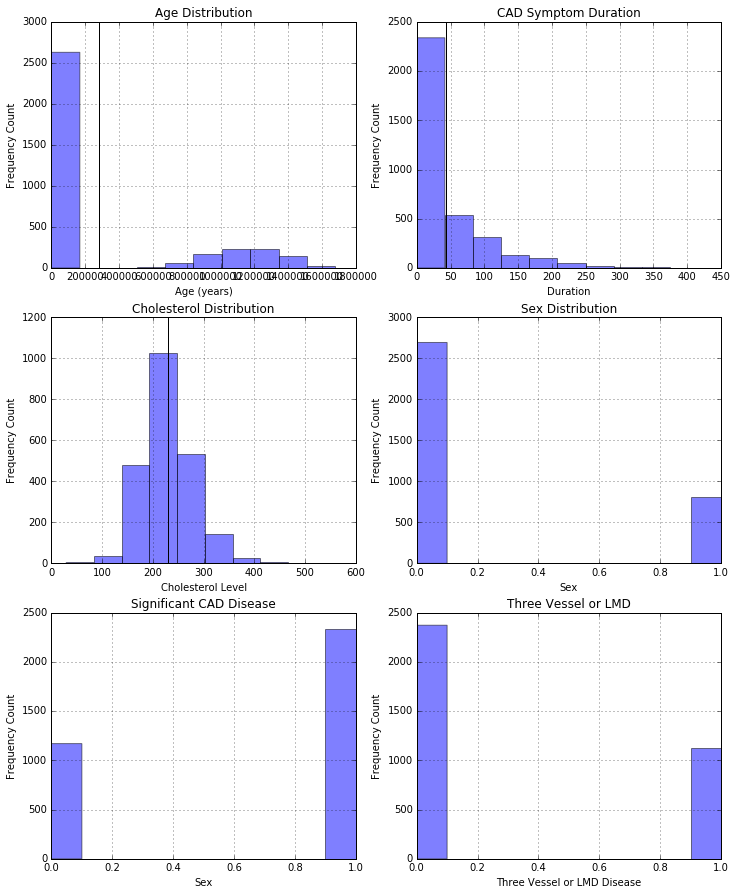

In [102]:
# add noise to 25% of the data
sex_list = cathdata['sex']
age_list = cathdata['age']
cadsym_list = cathdata['cad.dur']
chol_list = cathdata['choleste']
sigcad_list = cathdata['sigdz']
tvdlm_list = cathdata['tvdlm']

# get number of trials
num_trials = len(sex_list)

# distort the data for age
# sex_list[int(round(num_trials*0.75)):len(age_list)] = 0*sex_list[int(round(num_trials*0.75)):len(age_list)]
age_list[int(round(num_trials*0.75)):len(age_list)] = 12*age_list[int(round(num_trials*0.75)):len(age_list)]

# Plot summary of each variable
fig = plt.figure(figsize=(12, 15))
plt.subplot(3,2,1)
age_list.hist(alpha=0.5)
plt.axvline(np.mean(age_list), color='black')
plt.title('Age Distribution')
plt.xlabel('Age (years)')
plt.ylabel('Frequency Count')

plt.subplot(3,2,2)
cadsym_list.hist(alpha=0.5)
plt.axvline(np.mean(cadsym_list), color='black')
plt.title('CAD Symptom Duration')
plt.xlabel('Duration')
plt.ylabel('Frequency Count')

plt.subplot(3,2,3)
chol_list.hist(alpha=0.5)
plt.axvline(np.mean(chol_list), color='black')
plt.title('Cholesterol Distribution')
plt.xlabel('Cholesterol Level')
plt.ylabel('Frequency Count')

plt.subplot(3,2,4)
sex_list.hist(alpha=0.5)
plt.title('Sex Distribution')
plt.xlabel('Sex')
plt.ylabel('Frequency Count')

plt.subplot(3,2,5)
sigcad_list.hist(alpha=0.5)
plt.title('Significant CAD Disease')
plt.xlabel('Sex')
plt.ylabel('Frequency Count')

plt.subplot(3,2,6)
tvdlm_list.hist(alpha=0.5)
plt.title('Three Vessel or LMD')
plt.xlabel('Three Vessel or LMD Disease')
plt.ylabel('Frequency Count')

# count number of NaN's
print "Age nan's, ", age_list.isnull().sum()
print "CAD Symptom Duration nan's, ", cadsym_list.isnull().sum()
print "Cholesterol nan's, ", chol_list.isnull().sum()
print "Significant CAD nan's, ", sigcad_list.isnull().sum()
print "TVDLM nan's, ", tvdlm_list.isnull().sum()

In [103]:
# drop nan entries of data
cleanedcathdata = cathdata.dropna()
features = cleanedcathdata[['sex', 'age', 'cad.dur', 'choleste']]
target_sigdz = cleanedcathdata['sigdz']
target_tvdlm = cleanedcathdata['tvdlm']

# create a cross-validation test/train split
X_train, X_test, y_train, y_test = train_test_split(features, target_sigdz, test_size=0.3, random_state=0)

# initialize the logistic model 
logistic = linear_model.LogisticRegression()

Cs = np.logspace(-4, 4, 5)
penalty = ['l1', 'l2']

# create a pipe of our different operations
pipe = Pipeline(steps=[('logistic', logistic)])

# create a grid search on different combination of parameters
estimator = GridSearchCV(pipe, dict(
        logistic__C = Cs,
        logistic__penalty = penalty
    ))

estimator.fit(X_train, y_train)
print estimator.score(X_test, y_test)
print estimator.best_params_

y_predict = estimator.predict(X_test)
report = sklearn.metrics.classification_report(y_test, y_prediction)
print report

0.719764011799
{'logistic__C': 1.0, 'logistic__penalty': 'l1'}
             precision    recall  f1-score   support

          0       0.68      0.49      0.57       256
          1       0.73      0.86      0.79       422

avg / total       0.71      0.72      0.71       678



## 5. Feature Importance and Selection

[[ -1.85712088e+00  -4.78531907e-07   2.40575743e-03   7.99305476e-03]]


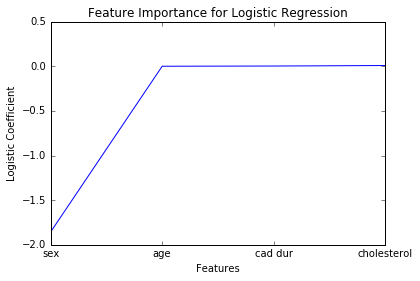

In [105]:
# make the logistic model again
logistic = linear_model.LogisticRegression(penalty='l1', C=10000)
logistic.fit(X_train, y_train)

# Plotting feature importance
fig = plt.figure()
plt.plot(logistic.coef_[0],)
plt.xticks(np.arange(0,4), ['sex', 'age', 'cad dur', 'cholesterol'])
plt.xlabel('Features')
plt.ylabel('Logistic Coefficient')
plt.title('Feature Importance for Logistic Regression')
print logistic.coef_

In [90]:
# drop nan entries of data
cleanedcathdata = cathdata.dropna()
features = cleanedcathdata[['age', 'cad.dur', 'choleste']]
target_sigdz = cleanedcathdata['sigdz']
target_tvdlm = cleanedcathdata['tvdlm']

# create a cross-validation test/train split
X_train, X_test, y_train, y_test = train_test_split(features, target_sigdz, test_size=0.3, random_state=0)

logistic = linear_model.LogisticRegression(penalty='l1', C=10000)
logistic.fit(X_train, y_train)
print logistic.score(X_test, y_test)

# drop nan entries of data
cleanedcathdata = cathdata.dropna()
features = cleanedcathdata[['sex', 'cad.dur', 'choleste']]
target_sigdz = cleanedcathdata['sigdz']
target_tvdlm = cleanedcathdata['tvdlm']

# create a cross-validation test/train split
X_train, X_test, y_train, y_test = train_test_split(features, target_sigdz, test_size=0.3, random_state=0)

logistic = linear_model.LogisticRegression(penalty='l1', C=10000)
logistic.fit(X_train, y_train)
print logistic.score(X_test, y_test)

# drop nan entries of data
cleanedcathdata = cathdata.dropna()
features = cleanedcathdata[['sex', 'age', 'choleste']]
target_sigdz = cleanedcathdata['sigdz']
target_tvdlm = cleanedcathdata['tvdlm']

# create a cross-validation test/train split
X_train, X_test, y_train, y_test = train_test_split(features, target_sigdz, test_size=0.3, random_state=0)

logistic = linear_model.LogisticRegression(penalty='l1', C=10000)
logistic.fit(X_train, y_train)
print logistic.score(X_test, y_test)


# drop nan entries of data
cleanedcathdata = cathdata.dropna()
features = cleanedcathdata[['sex', 'cad.dur', 'age']]
target_sigdz = cleanedcathdata['sigdz']
target_tvdlm = cleanedcathdata['tvdlm']

# create a cross-validation test/train split
X_train, X_test, y_train, y_test = train_test_split(features, target_sigdz, test_size=0.3, random_state=0)

logistic = linear_model.LogisticRegression(penalty='l1', C=10000)
logistic.fit(X_train, y_train)
print logistic.score(X_test, y_test)

0.672566371681
0.727138643068
0.744837758112
0.740412979351
